### 1.
Intraday on-shore wind power generation measured every hour for one year is available from the csv file WindGeneration.csv. Load the data into your computer and produce a graphic showing the time series of the wind generation over time. Is there evidence of annual seasonality?

In [1]:
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import datetime
import time

wind = read_csv(
    'WindGeneration.csv', header=0, encoding="latin1", na_values=['-'])
wind.interpolate(inplace=True)

d = wind.loc[:, 'Date'].tolist()
t = wind.loc[:, 'Time'].tolist()

for i in range(len(t)):
    if len(str(t[i])) < 2:
        t[i] = "0" + str(t[i])
    else:
        t[i] = str(t[i])
    if t[i] == "24":
        t[i] = "00"

pattern = "%d/%m/%Y:%H"
dateTime = []
for i in range(len(d)):
    DT = "{}:{}".format(d[i], t[i])
    strp = time.strptime(DT, pattern)
    DT = time.strftime(pattern, strp)
    dateTime.append(DT)

wind['DateTime'] = pd.Series(dateTime, index=wind.index)
wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 4 columns):
Date               8760 non-null object
Time               8760 non-null int64
Wind Generation    8760 non-null float64
DateTime           8760 non-null object
dtypes: float64(1), int64(1), object(2)
memory usage: 273.8+ KB


In [24]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

N = len(wind["Wind Generation"])
ind = np.arange(N)


def format_date(x, pos=None):
    thisind = np.clip(int(x + 0.5), 0, N - 1)
    return wind["Date"][thisind]

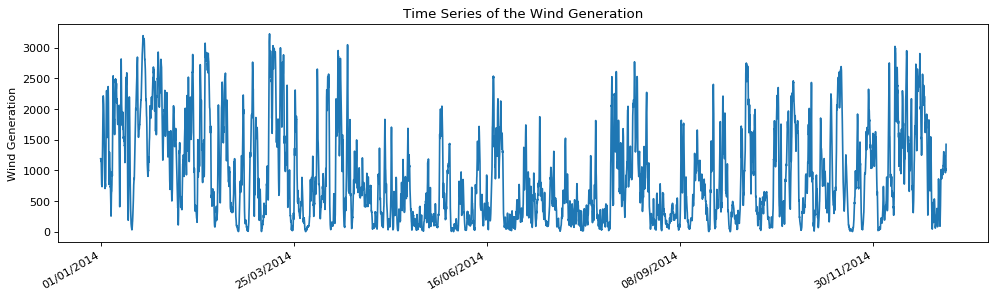

In [3]:
fig, ax = plt.subplots(figsize=(15, 4), dpi=80)
ax.plot(ind, wind["Wind Generation"])
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))

ax.set_ylabel('Wind Generation')
ax.set_title("Time Series of the Wind Generation")
fig.autofmt_xdate()

plt.show()

### 2.
Plot the change in wind generation over time as a percentage of the maximum generation. Is there evidence of annual seasonality?

In [4]:
def change(x, d):
    N = len(x)
    change = []
    for i in range(N):
        if i <= d:
            change.append(np.NaN)
        else:
            change.append(round((x[i] - x[i - d]) / x[i - d] * 100, 4))
    return change


change = change(wind["Wind Generation"], 1)
wind['Change (%)'] = pd.Series(change, index=wind.index)

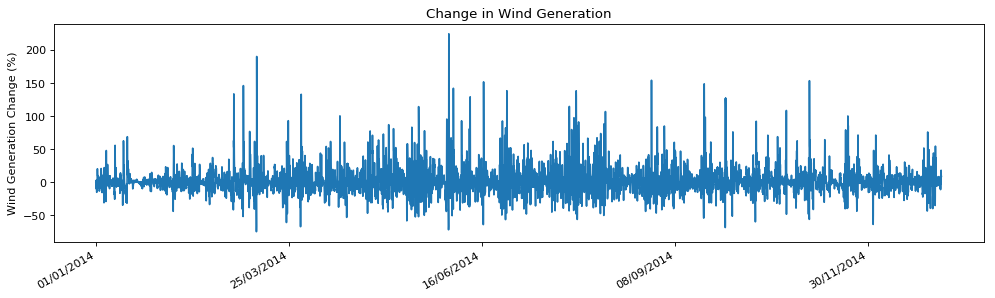

In [5]:
fig, ax = plt.subplots(figsize=(15, 4), dpi=80)
ax.plot(ind, wind["Change (%)"])
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))

ax.set_ylabel('Wind Generation Change (%)')
ax.set_title("Change in Wind Generation")
fig.autofmt_xdate()

plt.show()

### 3. 
Consider positive and negative ramps in wind power generation, x(t), as a percentage of the maximum, over the hourly timescale. An hourly ramp is therefore defined as **r(t,d) =100*[x(t+d)- x(t)]/max(x)** where d=1 for an hourly sampling period. Construct empirical **cumulative distribution functions (CDF)** for both the positive and negative ramps and plot these with the probability on a vertical logarithmic axis. Plot the CDF for a normal distribution with mean-zero and standard deviation from the observations. Is the normal distribution a good model for wind power extremes?

In [6]:
def get_ramp(x, d):
    N = len(x)
    ramp = []
    for i in range(N):
        if i <= d - 1:
            ramp.append(np.NaN)
        else:
            ramp.append(round((x[i] - x[i - d]) / max(x) * 100, 4))
    return ramp


ramp = get_ramp(wind["Wind Generation"], 1)
# wind['Ramp (%)'] = pd.Series(ramp, index=wind.index)

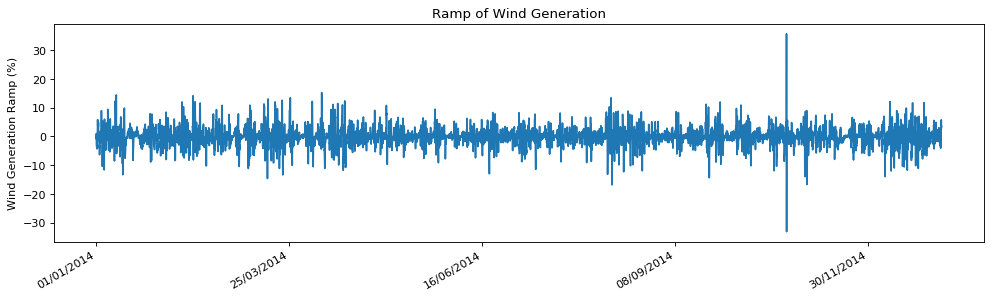

In [7]:
fig, ax = plt.subplots(figsize=(15, 4), dpi=80)
ax.plot(ind, ramp)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))

ax.set_ylabel('Wind Generation Ramp (%)')
ax.set_title("Ramp of Wind Generation")
fig.autofmt_xdate()

plt.show()

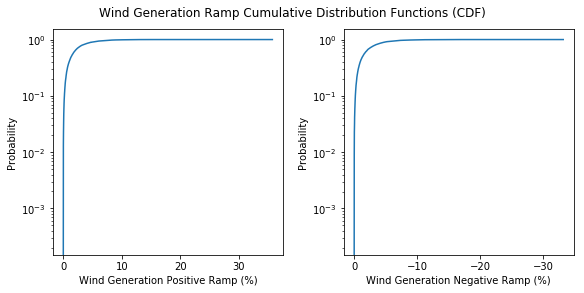

In [8]:
pramp = []
nramp = []
for r in ramp:
    if r >= 0:
        pramp.append(r)
    elif r <= 0:
        nramp.append(r)

Np = len(pramp)
Nn = len(nramp)

fig, axes = plt.subplots(ncols=2, figsize=(8, 4), constrained_layout=True)

### Positive
ax = axes[0]
X = np.sort(pramp)
F = np.array(range(Np)) / float(Np)

ax.set_xlabel('Wind Generation Positive Ramp (%)')
ax.set_ylabel('Probability')
# ax.set_title("Wind Generation Ramp Cumulative Distribution Functions (CDF)")

ax.plot(X, F)
ax.set_yscale('log')

### Negative
ax = axes[1]
X = np.sort(nramp)[::-1]
F = np.array(range(Nn)) / float(Nn)

ax.set_xlabel('Wind Generation Negative Ramp (%)')
ax.set_ylabel('Probability')
# ax.set_title("Wind Generation Negative Ramp Cumulative Distribution Functions (CDF)")

ax.plot(X, F)
ax.set_yscale('log')
ax.set_xlim(ax.get_xlim()[::-1])

fig.suptitle("Wind Generation Ramp Cumulative Distribution Functions (CDF)")
plt.show()

In [9]:
ramp_arr = np.array(ramp[1:])
sigma = np.std(ramp_arr)
s = np.random.normal(0, sigma, N - 1)

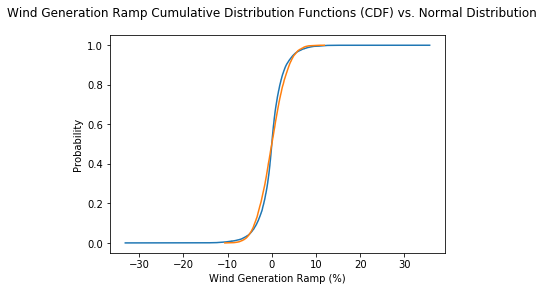

In [10]:
fig, ax = plt.subplots()

X = np.sort(ramp_arr)
s = np.sort(s)
F = np.array(range(N - 1)) / float(N - 1)

ax.set_xlabel('Wind Generation Ramp (%)')
ax.set_ylabel('Probability')
ax.plot(X, F, s, F)

fig.suptitle(
    "Wind Generation Ramp Cumulative Distribution Functions (CDF) vs. Normal Distribution"
)
plt.show()

### 4. 
National power system operators are tasked with the challenge of balancing supply and demand. They need to understand the variability in wind generation over different timescales. Investigate variability over timescales from one hour to one day by plotting the 1%, 5%, 95% and 99% percentiles. This can be achieved using distributions of the ramps r(t,d) with d =1,2,...,24.


In [11]:
def get_rampd(x,d_start,d_stop):
    ramps = []
    ds = []
    N = len(x)
    for d in range(d_start,d_stop+1):
        for i in range(N):
            if i >= d:
                ramps.append(round((x[i] - x[i - d]) / max(x) * 100, 4))
                ds.append(d)
    return ramps, ds

ramps, ds = get_rampd(wind["Wind Generation"],1,24)

ramps_ds = pd.DataFrame()
ramps_ds["Ramp"] = pd.Series(ramps)
ramps_ds["d"] = pd.Series(ds)

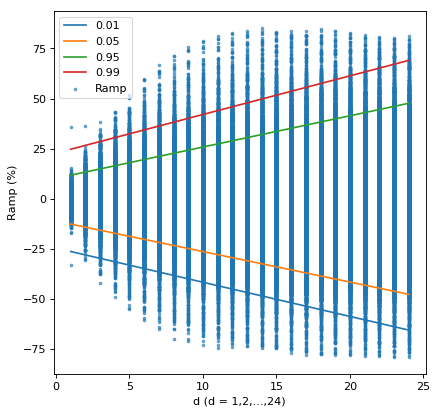

In [18]:
import statsmodels.formula.api as smf

model = smf.quantreg('Ramp ~d', ramps_ds)
quantiles = [0.01, 0.05, 0.95, 0.99]
fits = [model.fit(q=q) for q in quantiles]

fig, ax = plt.subplots(figsize=(6, 6), dpi=80)

x = ramps_ds['d']
ax.scatter(x, ramps_ds['Ramp'], alpha=0.6, s = 5)
_x = np.linspace(x.min(), x.max())

for index, quantile in enumerate(quantiles):
    # Plot the quantile lines
    _y = fits[index].params['d'] * _x + fits[index].params['Intercept']
    ax.plot(_x, _y, label=quantile)

ax.legend()
ax.set_xlabel('d (d = 1,2,...,24)')
ax.set_ylabel('Ramp (%)');

### 5. 
Calculate and plot the autocorrelation of wind generation for lags over 10 days. Comment on the structure of the autocorrelation.

In [25]:
acorr_gen = []
for i in range(1, 24 * 10 + 1):
    acorr_gen.append(wind["Wind Generation"].autocorr(lag=i))

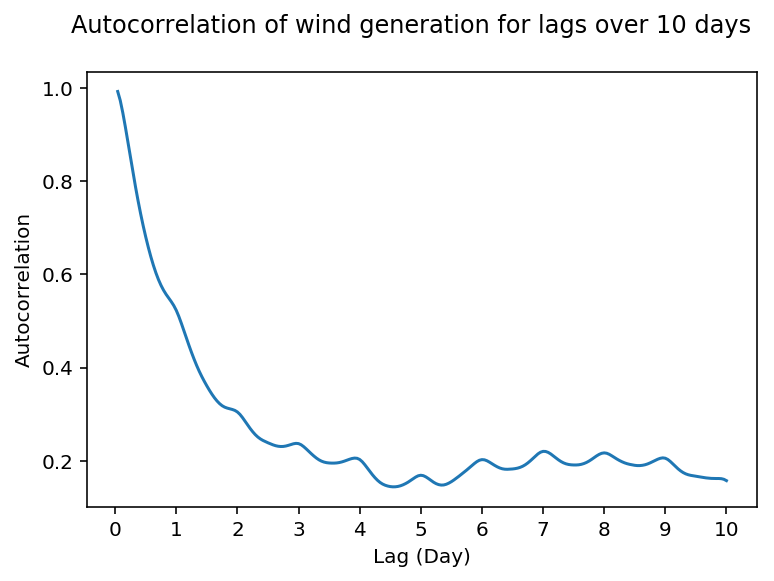

In [26]:
L = []
for i in range(1, 24 * 10 + 1):
    L.append(i / 24)

fig, ax = plt.subplots()

ax.plot(L, acorr_gen)

ax.set_xlabel('Lag (Day)')
ax.set_ylabel('Autocorrelation')

plt.xticks(np.arange(0, 11, step=1))
fig.suptitle("Autocorrelation of wind generation for lags over 10 days")
plt.show()

### 6. 
Calculate and plot the autocorrelation of change in wind generation for lags over 10 days. Include horizontal lines to detect statistically significance values (p<0.05). Is there any evidence of diurnal seasonality? Might it be more appropriate to model the change in wind generation than the wind generation?

In [22]:
acorr_change = []
for i in range(1, 24 * 10 + 1):
    acorr_change.append(wind["Change (%)"].autocorr(lag=i))

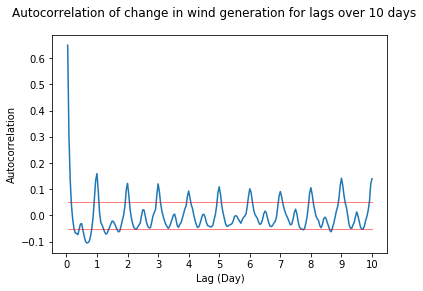

In [23]:
fig, ax = plt.subplots()

ax.plot(L, acorr_change)
ax.plot(L, [0.05] * len(L), 'r', linewidth=1, alpha=0.5)
ax.plot(L, [-0.05] * len(L), 'r', linewidth=1, alpha=0.5)

ax.set_xlabel('Lag (Day)')
ax.set_ylabel('Autocorrelation')

plt.xticks(np.arange(0, 11, step=1))
fig.suptitle(
    "Autocorrelation of change in wind generation for lags over 10 days")
plt.show()

### 7. 
Use a variance ratio test to investigate the structure of the wind generation time series. Can the null hypothesis of a random walk be rejected? Is there evidence of either mean-reversion of mean- aversion?